# Import

In [1]:
# Basic Libs
import os
import random
import numpy as np
import pandas as pd

# Image Process
from skimage.data import imread
from skimage.morphology import label

# Model Framework
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Helper Function
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Read Label

In [2]:
input_dir = '../../ShipDetect/'
train_img_dir = '../../ShipDetect/train/'
test_img_dir = '../../ShipDetect/test/'

In [3]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations_v2.csv')

In [4]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
train_df.shape

(231723, 2)

# Check Non-ship pictures

In [6]:
def checkNaN(x):
    return 0 if x==x else 1

In [7]:
train_df['isnan'] = train_df['EncodedPixels'].apply(checkNaN)

In [8]:
train_df['isnan'].value_counts()

1    150000
0     81723
Name: isnan, dtype: int64

In [9]:
# Remove 100000 Non-ship samples
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[100000:]

In [10]:
train_df['isnan'].value_counts()

0    81723
1    50000
Name: isnan, dtype: int64

In [11]:
# Remove the toxic image 
train_df = train_df[train_df['ImageId'] != '6384c3e78.jpg']

# Calculate total area for labeled data

In [12]:
def calc_area_for_rle(rle_str):
    rle_list = [int(x) if x.isdigit() else x for x in str(rle_str).split()]
    if len(rle_list) == 1:
        return 0
    else:
        area = np.sum(rle_list[1::2])
        return area

In [13]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

In [14]:
train_df_isship = train_df[train_df['area'] > 0]

In [15]:
# Filter data by area less than 10
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]
print(train_df_smallarea.shape[0]*1.0/train_df_isship.shape[0])

0.00123588218739


In [16]:
# group by imageid
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()
train_gp.head()

,ImageId,isnan,area
0,000155de5.jpg,0,3388
1,000194a2d.jpg,0,1460
2,0001b1832.jpg,1,0
3,00021ddc3.jpg,0,1176
4,0002756f7.jpg,0,408


# Train Data Distribution

In [17]:
def calc_class(area):
    area = area * 1.0/ (768*768)
    if area == 0:
        return 0
    elif area < 0.005:
        return 1
    elif area < 0.015:
        return 2
    elif area < 0.025:
        return 3
    elif area < 0.035:
        return 4
    elif area < 0.045:
        return 5
    else:
        return 6

In [18]:
train_gp['class'] = train_gp['area'].apply(calc_class)
train_gp['class'].value_counts()

0    49999
1    29315
2     9225
3     2644
4     1122
5      181
6       69
Name: class, dtype: int64

# Split Train-Valid

In [19]:
train, val = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [20]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

In [21]:
print(len(train_isship_list),len(train_nanship_list))

(42130, 49499)


# Data Pipeline

In [22]:
def rle_to_mask(rle_list, SHAPE):
    '''
    Translate labeled pixels to the mask in the image
    '''
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [23]:
def DataPipeline(isship, nanship, batchsize, cap):
    k = 0
    nanship_names, isship_names = nanship[:cap], isship[:cap]
    while True:
        if k+batchsize//2 >= cap:
            k = 0
        batch_nanship_names = nanship_names[k:k+batchsize//2]
        batch_isship_names = isship_names[k:k+batchsize//2]
        batch_img, batch_mask = [], []
        
        for name in batch_nanship_names:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
            
        for name in batch_isship_names:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
            
        img = np.stack(batch_img, axis=0)
        mask = np.stack(batch_mask, axis=0)
        img = img / 255.0
        mask = mask / 255.0
        k += batchsize//2
        yield img, mask

In [49]:
BATCHSIZE = 32
CAP = min(len(train_isship_list),len(train_nanship_list))
datagen = DataPipeline(train_isship_list, train_nanship_list, BATCHSIZE, CAP)

# Define Model

In [50]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6),interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 768, 768, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 768, 768, 8)  32          conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 768, 768, 8)  584         batch_normalization_27[0][0]     
__________________________________________________________________________________________________
batch_norm

In [52]:
model.load_weights('../models/checkpoint.hdf5')

In [53]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# Train

In [54]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='../log', histogram_freq=0, write_graph=True, write_images=True)
saveCallBack = keras.callbacks.ModelCheckpoint('../models/checkpoint.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
CallBackList = [tbCallBack, saveCallBack]

In [55]:
history = model.fit_generator(datagen, steps_per_epoch = 100, epochs = 200, callbacks=CallBackList)

Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[32,8,768,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_53/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training_1/Adam/gradients/batch_normalization_51/cond/Merge_grad/cond_grad"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_51/cond/Merge, conv2d_53/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_1/mul/_4745}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_10163_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


# Predict for validation set

In [31]:
def calc_IoU(A, B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() * 1.0 / AorB.sum()
    return IoU

In [32]:
def calc_IoU_vector(A, B):
    score_vector = []
    IoU = calc_IoU(A, B)
    for threshold in np.arange(0.5,1,0.05):
        score = int(IoU > threshold)
        score_vector.append(score)
    return score_vector

In [33]:
def calc_IoU_tensor(masks_true, masks_pred):
    true_mask_num = masks_true.shape[0]
    pred_mask_num = masks_pred.shape[0]
    score_tensor = np.zeros((true_mask_num, pred_mask_num, 10))
    for true_i in range(true_mask_num):
        for pred_i in range(pred_mask_num):
            true_mask = masks_true[true_i]
            pred_mask = masks_pred[pred_i]
            score_vector = calc_IoU_vector(true_mask, pred_mask)
            score_tensor[true_i,pred_i,:] = score_vector
    return score_tensor

In [34]:
def calc_F2_per_one_threshold(score_matrix):
    tp = np.sum( score_matrix.sum(axis=1) > 0  )
    fn = np.sum( score_matrix.sum(axis=1) == 0 )
    fp = np.sum( score_matrix.sum(axis=0) == 0 )
    F2 = (5*tp) * 1.0 / ((5*tp) + fp + (4*fn))
    return F2

In [35]:
def calc_score_one_image(mask_true, mask_pred):
    mask_true = mask_true.reshape(768,768)
    mask_pred = mask_pred.reshape(768,768)
    if mask_true.sum() == 0 and mask_pred.sum() == 0:
        score = 1
    elif mask_true.sum() == 0 and mask_pred.sum() != 0:
        score = 0
    elif mask_true.sum() != 0 and mask_pred.sum() == 0:
        score = 0
    else:
        mask_label_true = label(mask_true)
        mask_label_pred = label(mask_pred)
        c_true = np.max(mask_label_true)
        c_pred = np.max(mask_label_pred)
        tmp = []
        for k in range(c_true):
            tmp.append(mask_label_true == k+1)
        masks_true = np.stack(tmp, axis=0)
        tmp = []
        for k in range(c_pred):
            tmp.append(mask_label_pred == k+1)
        masks_pred = np.stack(tmp, axis=0)
        score_tensor = calc_IoU_tensor(masks_true, masks_pred)
        F2_t = []
        for i in range(10):
            F2 = calc_F2_per_one_threshold(score_tensor[:,:,i])
            F2_t.append(F2)
        score = np.mean(F2_t)
    return score

In [36]:
def calc_score_all_image(batch_mask_true, batch_mask_pred, threshold=0.5):
    num = batch_mask_true.shape[0]
    tmp = batch_mask_pred > threshold
    batch_mask_pred = tmp.astype('int')
    scores = list()
    for i in range(num):
        score = calc_score_one_image(batch_mask_true[i], batch_mask_pred[i])
        scores.append(score)
    return np.mean(scores)

In [37]:
# Preprocess validation set
val_list = val['ImageId'].tolist()

In [38]:
def create_data(image_list):
    batch_img = []
    batch_mask = []
    for name in image_list:
        tmp_img = imread(train_img_dir + name)
        batch_img.append(tmp_img)
        mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
        one_mask = np.zeros((768, 768, 1))
        for item in mask_list:
            rle_list = str(item).split()
            tmp_mask = rle_to_mask(rle_list, (768, 768))
            one_mask[:,:,0] += tmp_mask
        batch_mask.append(one_mask)
    img = np.stack(batch_img, axis=0)
    mask = np.stack(batch_mask, axis=0)
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

In [39]:
from tqdm import tqdm

In [40]:
#search threshold
scores_list = dict()
threshold_list = [x*1.0/100 for x in range(20,80,10)]
for threshold in threshold_list:
    scores = []
    for i in tqdm(range(len(val_list)//2)):
        temp_list = val_list[i*2:(i+1)*2]
        val_img, val_mask = create_data(temp_list)
        pred_mask = model.predict(val_img)
        F2 = calc_score_all_image(val_mask, pred_mask, threshold=threshold)*2
        scores.append(F2)
    val_F2 = np.sum(scores)* (1.0/(len(val_list)//2) *2)
    scores_list[threshold] = val_F2

100%|██████████| 463/463 [01:36<00:00,  5.11it/s]


In [41]:
scores_list

{0.2: 2.1025912024433127,
 0.3: 2.2105358648814666,
 0.4: 2.2666624728379388,
 0.5: 2.2718388686397226,
 0.6: 2.2564267381959593,
 0.7: 2.209735623936077}

In [42]:
opt_threshold = max(scores_list, key=scores_list.get)

In [43]:
opt_threshold

0.5

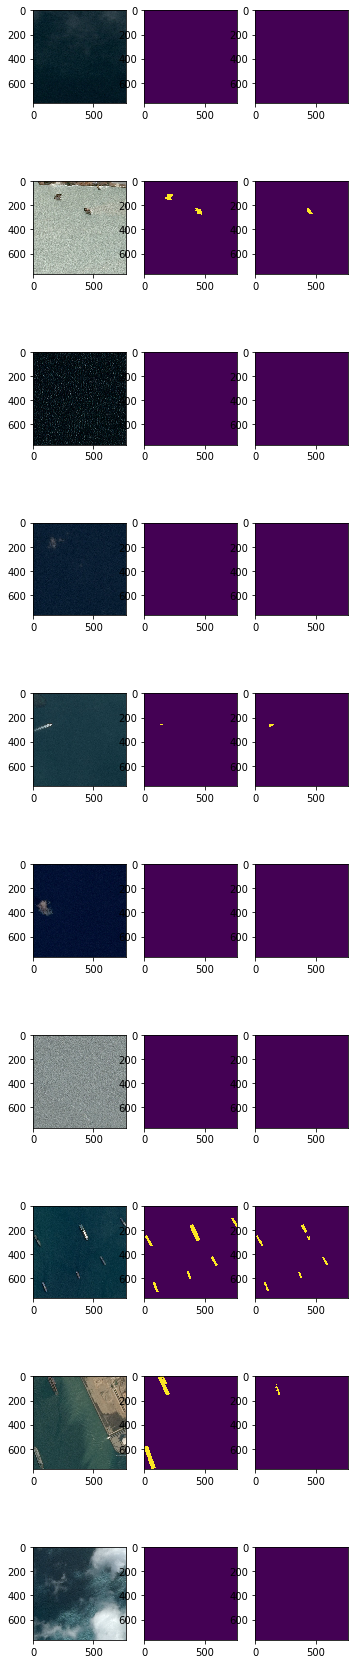

In [44]:
image_list = val_list[20:30]
fig, axes = plt.subplots(len(image_list), 3, figsize=(5,5*len(image_list)))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]])
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)

# Predict for Submission

In [45]:
test_names = [x.split('.')[0] for x in os.listdir(test_img_dir)]

In [46]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img[0,:,:,:])
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [47]:
pred_rows = []
for name in tqdm(test_names):
    test_img = imread(test_img_dir + name + '.jpg')
    test_img_1 = test_img.reshape(1,768,768,3)/255.0
    test_img_2 = test_img_1[:, :, ::-1, :]
    test_img_3 = test_img_1[:, ::-1, :, :]
    test_img_4 = test_img_1[:, ::-1, ::-1, :]
    pred_prob_1 = model.predict(test_img_1)
    pred_prob_2 = model.predict(test_img_2)
    pred_prob_3 = model.predict(test_img_3)
    pred_prob_4 = model.predict(test_img_4)
    pred_prob = (pred_prob_1 + pred_prob_2[:, :, ::-1, :] + pred_prob_3[:, ::-1, :, :] + pred_prob_4[:, ::-1, ::-1, :])*1.0/4
    pred_mask = pred_prob > opt_threshold
    rles = multi_rle_encode(pred_mask)
    if len(rles)>0:
        for rle in rles:
            pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': rle}]
    else:
        pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': None}]

100%|██████████| 15606/15606 [57:44<00:00,  4.55it/s] 


In [48]:
submission_df = pd.DataFrame(pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission_2018_11_27_opt_threshold.csv', index=False)